In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Moving Average Models for Forecasting

The residual errors from forecasts on a time series provide another source of information that
we can model. Residual errors themselves form a time series that can have temporal structure.
A simple autoregression model of this structure can be used to predict the forecast error, which
in turn can be used to correct forecasts. This type of model is called a moving average model,
the same name but very dierent from moving average smoothing.

### Moving Average Models for Forecasting

The difference between what was expected and what was predicted is called the residual error.

$$residual\>error = expected - predicted$$

### Persistence Forecast Model

The simplest forecast that we can make is to forecast that what happened in the previous time
step will be the same as what will happen in the next time step. This is called the naive forecast
or the persistence forecast model.

In [7]:
df = pd.read_csv('./dataset/daily-total-female-births.csv', index_col='Date', parse_dates=['Date'])
df.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [10]:
new_df = pd.DataFrame({
    't': df.iloc[:, 0].shift(1),
    't+1': df.values.flatten()
})
new_df

,t,t+1
Date,,
1959-01-01,NaN,35
1959-01-02,35.0,32
1959-01-03,32.0,30
1959-01-04,30.0,31
1959-01-05,31.0,44
...,...,...
1959-12-27,34.0,37
1959-12-28,37.0,52
1959-12-29,52.0,48


In [16]:
from sklearn.model_selection import TimeSeriesSplit

X = new_df.values
splits = TimeSeriesSplit(n_splits=4)

for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print(f'train: {len(train)}, test: {len(test)}')

X_train, y_train = train[:, 0], train[:, 1]
X_test, y_test = test[:, 0], test[:, 1]

train: 73, test: 73
train: 146, test: 73
train: 219, test: 73
train: 292, test: 73


In [21]:
from sklearn.metrics import mean_squared_error

# persistence model
predictions = X_test.copy()

# skill of persistence model
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Test RMSE: {rmse}')

# calculate residuals
residuals = pd.DataFrame([y_test[i] - predictions[i] for i in range(len(predictions))])
residuals.head()

Test RMSE: 7.698959189574895


,0
0,-1.0
1,-4.0
2,9.0
3,-9.0
4,-2.0


## Autoregression of Residual Error

We can model the residual error time series using an autoregression model. This is a linear
regression model that creates a weighted linear sum of lagged residual error terms. For example:

$$error(t+1) = b_0 + (b_1 \times error(t)) + (b_2 \times error(t-1)) \dots + (b_n \times error(t-n)))$$

In [28]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.ar_model import AR

X = new_df.values[1:]
splits = TimeSeriesSplit(n_splits=4)

for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print(f'train: {len(train)}, test: {len(test)}')

X_train, y_train = train[:, 0], train[:, 1]
X_test, y_test = test[:, 0], test[:, 1]

# persistence model on training set
train_pred = X_train.copy()

# calculate residuals
train_resid = [y_train[i] - train_pred[i] for i in range(len(train_pred))]

# model the training set residuals
model = AR(train_resid)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

print('Lag=%d,\nCoef=%s' % (window, coef))

train: 76, test: 72
train: 148, test: 72
train: 220, test: 72
train: 292, test: 72
Lag=16,
Coef=[ 0.07289779 -0.85436117 -0.78406841 -0.73259552 -0.71191466 -0.62810716
 -0.60598827 -0.39980478 -0.28467975 -0.23672833 -0.16863121 -0.08607937
 -0.12146062 -0.10187739 -0.0402212   0.00548516  0.03922307]


## Walk Forward

predicted error=3.107857, expected error=-4.000000
predicted error=5.120626, expected error=9.000000
predicted error=-0.579633, expected error=-9.000000
predicted error=8.527920, expected error=-2.000000
predicted error=6.735571, expected error=6.000000
predicted error=0.892850, expected error=-7.000000
predicted error=8.206612, expected error=-7.000000
predicted error=11.488778, expected error=16.000000
predicted error=-2.150519, expected error=-8.000000
predicted error=3.868502, expected error=9.000000
predicted error=-4.509871, expected error=1.000000
predicted error=-4.773422, expected error=2.000000
predicted error=-6.250978, expected error=1.000000
predicted error=-10.490662, expected error=-6.000000
predicted error=-1.900614, expected error=-1.000000
predicted error=-0.905491, expected error=17.000000
predicted error=-15.441746, expected error=-14.000000
predicted error=-0.671805, expected error=7.000000
predicted error=-5.795231, expected error=-6.000000
predicted error=-0.9007

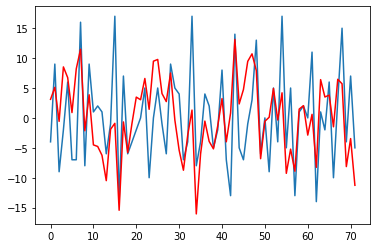

In [48]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.ar_model import AR

X = new_df.values[1:]
splits = TimeSeriesSplit(n_splits=4)

for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]

X_train, y_train = train[:, 0], train[:, 1]
X_test, y_test = test[:, 0], test[:, 1]

# persistence model on training set
train_pred = X_train.copy()

# calculate residuals
train_resid = [y_train[i] - train_pred[i] for i in range(len(train_pred))]

# model the training set residuals
model = AR(train_resid)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train_resid[len(train_resid) - window:]
history = [history[i] for i in range(len(history))]
predictions = []
expected_error = []

for t in range(len(y_test)):
    # persistence
    y_pred = X_test[t]
    error = y_test[t] - y_pred
    expected_error.append(error)
    
    # predict error
    length = len(history)
    lag = [history[i] for i in range(length - window, length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    predictions.append(pred_error)
    history.append(error)
    print('predicted error=%f, expected error=%f' % (pred_error, error))
plt.plot(expected_error)
plt.plot(predictions, color='red')
plt.show()

## Correct Predictions with a Model of Residuals

C:\Users\Angga\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


predicted=45.107857, expected=38.000000
predicted=43.120626, expected=47.000000
predicted=46.420367, expected=38.000000
predicted=46.527920, expected=36.000000
predicted=42.735571, expected=42.000000
predicted=42.892850, expected=35.000000
predicted=43.206612, expected=28.000000
predicted=39.488778, expected=44.000000
predicted=41.849481, expected=36.000000
predicted=39.868502, expected=45.000000
predicted=40.490129, expected=46.000000
predicted=41.226578, expected=48.000000
predicted=41.749022, expected=49.000000
predicted=38.509338, expected=43.000000
predicted=41.099386, expected=42.000000
predicted=41.094509, expected=59.000000
predicted=43.558254, expected=45.000000
predicted=44.328195, expected=52.000000
predicted=46.204769, expected=46.000000
predicted=45.099257, expected=42.000000
predicted=45.479040, expected=40.000000
predicted=43.034954, expected=40.000000
predicted=46.594182, expected=45.000000
predicted=46.437713, expected=35.000000
predicted=44.486109, expected=35.000000


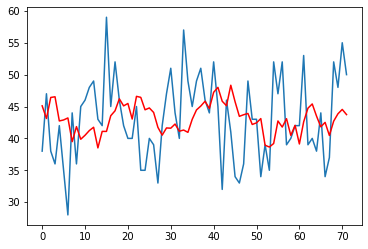

In [50]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.ar_model import AR

X = new_df.values[1:]
splits = TimeSeriesSplit(n_splits=4)

for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]

X_train, y_train = train[:, 0], train[:, 1]
X_test, y_test = test[:, 0], test[:, 1]

# persistence model on training set
train_pred = X_train.copy()

# calculate residuals
train_resid = [y_train[i] - train_pred[i] for i in range(len(train_pred))]

# model the training set residuals
model = AR(train_resid)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train_resid[len(train_resid) - window:]
history = [history[i] for i in range(len(history))]
predictions = []
expected_error = []

for t in range(len(y_test)):
    # persistence
    y_pred = X_test[t]
    error = y_test[t] - y_pred
    expected_error.append(error)
    
    # predict error
    length = len(history)
    lag = [history[i] for i in range(length - window, length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    # correct the prediction
    y_pred = y_pred + pred_error
    predictions.append(y_pred)
    history.append(error)
    print('predicted=%f, expected=%f' % (y_pred, y_test[t]))
# error
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('Test RMSE: %.3f' % rmse)

plt.plot(y_test)
plt.plot(predictions, color='red')
plt.show()